# auto encoder

## example auto encoder for analyzsing neural actvities.

In [12]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt


In [13]:
class autoencoder(nn.Module):
    def __init__(self, ninput, noutput):
        # this is a customized autoencoder
        # n input features and n output features.
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(ninput, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, 64),
                                     nn.ReLU(True),
                                     nn.Linear(64, 12),
                                     nn.ReLU(True),
                                     nn.Linear(12, 3))
        self.decoder = nn.Sequential(nn.Linear(3, 12),
                                     nn.ReLU(True),
                                     nn.Linear(12, 64),
                                     nn.ReLU(True),
                                     nn.Linear(64, 128),
                                     nn.ReLU(True),
                                     nn.Linear(128, noutput),
                                     nn.Tanh())
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [14]:

def get_data(batch_size = 128):
    # 将像素点转换到[-1, 1]之间，使得输入变成一个比较对称的分布，训练容易收敛
    data_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    train_dataset = datasets.MNIST(root='./data', train=True, transform=data_tf, download=True)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
    return train_loader

def to_img(x):
    x = (x + 1.) * 0.5
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x



In [19]:
# 超参数设置
batch_size = 128
lr = 1e-2
weight_decay = 1e-5
epoches = 1
model = autoencoder(28*28, 28*28)
# x = Variable(torch.randn(1, 28*28))
# encode, decode = model(x)
# print(encode.shape)
train_data = get_data()
criterion = nn.MSELoss()
optimizier = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if torch.cuda.is_available():
    model.cuda()
for epoch in range(epoches):
    if epoch in [epoches * 0.25, epoches * 0.5]:
        for param_group in optimizier.param_groups:
            param_group['lr'] *= 0.1
    for img, _ in train_data:
        img = img.view(img.size(0), -1)
        img = Variable(img.cuda())
        # forward
        _, output = model(img)
        loss = criterion(output, img)
        # backward
        optimizier.zero_grad()
        loss.backward()
        optimizier.step()
    print("epoch=", epoch, loss.data.float())
    for param_group in optimizier.param_groups:
        print(param_group['lr'])
    if (epoch+1) % 5 == 0:
        print("epoch: {}, loss is {}".format((epoch+1), loss.data))
        pic = to_img(output.cpu().data)
        if not os.path.exists('./simple_autoencoder'):
            os.mkdir('./trash')
        # save_image(pic, './trash/image_{}.png'.format(epoch + 1))
# torch.save(model, './autoencoder.pth')
# model = torch.load('./autoencoder.pth')


epoch= 0 tensor(0.1622, device='cuda:0')
0.01


In [27]:
img.shape

torch.Size([128, 784])

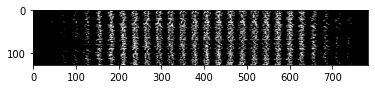

In [24]:
plt.imshow((img.data.cpu().numpy() * 255).astype('uint8'), cmap='gray')

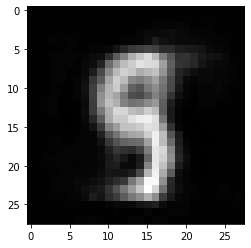

In [25]:
code = Variable(torch.FloatTensor([[1.19, -3.36, 2.06]]).cuda())
decode = model.decoder(code)
decode_img = to_img(decode).squeeze()
decode_img = decode_img.data.cpu().numpy() * 255
plt.imshow(decode_img.astype('uint8'), cmap='gray')
plt.show()

In [26]:
decode_img.shape

(28, 28)

In [81]:
# transformer test


import torch
import torch.nn as nn
import numpy as np

class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads):
        super(Transformer, self).__init__()
        self.encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=num_layers)
        self.linear = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.linear(x)
        return x

# Define model parameters
input_size = 88
hidden_size = 5
num_layers = 3
num_heads = 8

# Create an instance of the transformer model
model = Transformer(input_size, hidden_size, num_layers, num_heads)

# Calculate the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Parameters:", total_params)


Total Parameters: 1577501


In [91]:
# bert

import torch
from transformers import BertModel, BertTokenizer, BertConfig

# Define model parameters
input_size = 512
hidden_size = 8
num_layers = 6
num_heads = 8

# Define BERT configuration
config = BertConfig(
    vocab_size=30522,  # Default vocabulary size for BERT-base
    hidden_size=hidden_size,
    num_hidden_layers=num_layers,
    num_attention_heads=num_heads,
    intermediate_size=hidden_size * 4,  # Typically 4 times the hidden size
    max_position_embeddings=input_size
)

# Load pre-trained BERT model with custom configuration
model = BertModel(config)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Example input text
text = "Hello, how are you doing todayasdfasdfasdf asdfasdf?"

# Tokenize input text
tokens = tokenizer.encode_plus(text, return_tensors="pt")

# Forward pass through BERT model
outputs = model(**tokens)

# Get the hidden states from BERT
hidden_states = outputs.last_hidden_state

# Retrieve the hidden states for the first token ([CLS] token)
first_token_hidden_states = hidden_states[:, 0, :]

# Print the shape of hidden states for the first token
print("Shape of hidden states for the first token:", first_token_hidden_states.shape)

# Print the hidden states for the first token
# print("Hidden states for the first token:", first_token_hidden_states)


Shape of hidden states for the first token: torch.Size([1, 8])


In [126]:
# seq seq ae

class Seq2SeqAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Seq2SeqAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers)
        self.decoder = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)
        
    def forward(self, x, reset_indices):
        # Encoding phase
        print('x', x.shape)
        _, (hidden, cell) = self.encoder(x)
        print('hidden', hidden.shape)
        print('cell', cell.shape)
        # Decoding phase
        output = []
        for i in range(x.size(0)):
            if i in reset_indices:
                hidden = torch.zeros_like(hidden)  # Reset hidden state
            out, (hidden, cell) = self.decoder(x[i:i+1], (hidden, cell))
            output.append(out)
        print(output)
        output = torch.cat(output, dim=0)
        return output

# Example parameters
input_size = 13
hidden_size = 16
num_layers = 2
batch_size = 32
num_epochs = 10
learning_rate = 0.001
sequence_length = 27

# Initialize model, loss function, and optimizer
model = Seq2SeqAutoencoder(input_size, hidden_size, num_layers)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Parameters:", total_params)

input=torch.rand(32,27,13)
print('\ninput (batch, seqlen, feature)\n', input.shape)
latent=model.encoder(input)
print('\nlatent (batch, seqlen, hidden)  \n', latent[0].shape)
print('\nhidden state, cell state (layer, seqlen, hidden)\n', latent[1][0].shape, latent[1][1].shape)
latent, (eh,ec)=model.encoder(input) # here the h and c are encoder hidden and cell state
# (seqlen, batch, latent)
out, (de,dc)=model.decoder(latent)
print('\n out (batch, seqlen, feature)\n', out.shape)

Total Parameters: 7228

input (batch, seqlen, feature)
 torch.Size([32, 27, 13])

latent (batch, seqlen, hidden)  
 torch.Size([32, 27, 16])

hidden state, cell state (layer, seqlen, hidden)
 torch.Size([2, 27, 16]) torch.Size([2, 27, 16])

 out (batch, seqlen, feature)
 torch.Size([32, 27, 13])


In [142]:
import torch
import torch.nn as nn

class LSTMEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.):
        super(LSTMEncoderDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.num_layers=num_layers

    def forward(self, input_seq, max_len):
        batch_size = input_seq.size(0)
        
        # Initialize hidden and cell states for encoder and decoder
        hidden_encoder = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(input_seq.device)
        cell_encoder = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(input_seq.device)
        
        hidden_decoder = hidden_encoder.clone()  # Initialize decoder hidden state with encoder's last hidden state
        cell_decoder = cell_encoder.clone()  # Initialize decoder cell state with encoder's last cell state
        
        # Encoder forward pass
        _, (hidden_encoder, cell_encoder) = self.encoder(input_seq, (hidden_encoder, cell_encoder))
        
        # Initialize decoder input with zeros
        decoder_input = torch.zeros(batch_size, 1, self.hidden_dim).to(input_seq.device)
        
        # Output sequence tensor
        output_seq = torch.zeros(batch_size, max_len, self.linear.out_features).to(input_seq.device)
        
        # Decoder forward pass
        for t in range(max_len):
            decoder_output, (hidden_decoder, cell_decoder) = self.decoder(decoder_input, (hidden_decoder, cell_decoder))
            output = self.linear(decoder_output.squeeze(1))
            output_seq[:, t, :] = output
            decoder_input = decoder_output  # Use output as input for the next time step
        
        output_seq = output_seq.flip(1)
        return output_seq

# Example usage
input_dim = 13
hidden_dim = 16
output_dim = input_dim
max_len = 27
batch_size=32
model = LSTMEncoderDecoder(input_dim, hidden_dim, output_dim)
input_seq = torch.randn(batch_size, max_len, input_dim)  # Example input sequence
print('\ninput (batch, seqlen, feature)\n', input_seq.shape)

output_seq = model(input_seq, max_len)
print('\n output (batch, seqlen, feature)\n', output_seq.shape)


total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Parameters:", total_params)



input (batch, seqlen, feature)
 torch.Size([32, 27, 13])

 output (batch, seqlen, feature)
 torch.Size([32, 27, 13])
Total Parameters: 8733
